# Insincere Question Analysis

In this section we will have an original task: Given a question, how do you know if it was a genuine question from someone who are searching for an answer, or merely asked for some other reasons?

## Input Data
### Load libraries

Nothing new here.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load dataset

The dataset is part of **Quora's <a href="https://www.kaggle.com/c/quora-insincere-questions-classification/data">Insincere Questions Classification</a> Competition**. You are free to explore the data as you see fit.

In [2]:
data = pd.read_csv("train.csv", header=0)

In [3]:
print("Number of questions: {:d}".format(len(data)))
print("Insincere percentile: {:.2f}%".format( float(len(data[data["target"] == 1])) / len(data) * 100.0))
print("Sample question (idx=6000): {:s}".format(data.iloc[6000]["question_text"]))
data.head(10)

Number of questions: 1306122
Insincere percentile: 6.19%
Sample question (idx=6000): What starters should a person avoid when engaging a conversation?


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


### Sampling

We can reduce the number of samples used in order to make the process faster, but this isn't proper.

In [4]:
sample_data = data.sample(frac=0.1, random_state=13)
print("Number of questions (sample): {:d}".format(len(sample_data)))
print("Insincere percentile (sample): {:.2f}%".format( float(len(sample_data[sample_data["target"] == 1])) / len(sample_data) * 100.0))
data = sample_data

Number of questions (sample): 130612
Insincere percentile (sample): 6.19%


### Tokenization

Unlike in our usual working on perfect data during the course, the `question_text` field had not yet tokenized. If you just blindly put them into a model, the performance would be atrocious (for, say, <u>conversation?</u> will be counted as a single token instead of two tokens <u>conversation</u> and <u>?</u>). Good thing that the questions are in english, and we already have a well-trusted tool for this matter: <a href="">NLTK</a>

In [5]:
!pip install nltk

In [6]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
data = data.rename(columns={"question_text": "raw_text"})
data["tokenized_text"] = data["raw_text"].map(lambda raw_text: (" ".join(word_tokenize(raw_text.strip()))).lower())
data.head(5)

[nltk_data] Downloading package punkt to /home/leanh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,qid,raw_text,target,tokenized_text
961946,bc768fbe7af71e7907ee,How do I view my boyfriend's call log?,0,how do i view my boyfriend 's call log ?
469183,5bdfa94ab3e7301e0d67,Are laundry mats safe to use or will you get b...,0,are laundry mats safe to use or will you get b...
1279716,face98c2b2f520b5c151,What is the CU college registration number of ...,0,what is the cu college registration number of ...
244661,2fda9c6f2ffbd4a365ce,How was Lost Tapes (TV documentary) created?,0,how was lost tapes ( tv documentary ) created ?
448591,57de4118196354f132fa,How many calories does each cup of green tea b...,0,how many calories does each cup of green tea b...


## Common topic modeling choices
### Build a model on the data

The easiest way to go on is to use good old sklearn's LDA as we learned them (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html">link</a>). Use CountVectorizer and LDA to search for underlying topics in the data. For this problem, we will assume to have 25 topics presented in the data.

*Note: The prefered arguments for CountVectorizer are max_df=0.98, min_df=5, ngram_range=(1, 2), stop_words="english". This avoid stop words, construct 2-grams and remove both too frequent and infrequent words. However, students are free to choose the arguments in general.*

Also, keep the component distribution. You will be grateful of it later.

In [7]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
# the number of topics
topic_count = 25
# Construct the CountVectorizer and create word count matrix
vectorizer = CountVectorizer(max_df=0.98, min_df=5, ngram_range=(1, 2), stop_words="english")
data_matrix = vectorizer.fit_transform(data['tokenized_text'])
# fit transform the LDA model on the word count
lda_model = LatentDirichletAllocation(n_components=topic_count, random_state=1)
lda_model.fit(data_matrix)

LatentDirichletAllocation(n_components=25, random_state=1)

### Interpret the topics generated

You are free to do whatever you want to demonstrate the topics that had been chosen. Our recommended practice is to use a function to extract the values per words.

In [8]:
def retrieve_top_words(topic, feature_names, n_top_words=3):
    # Note that `topic` will already contain a vector of [features]
    return np.array(feature_names)[np.argsort(-topic)][:n_top_words]

In [9]:
for topic_idx, topic in enumerate(lda_model.components_):
    top_words = retrieve_top_words(topic, vectorizer.get_feature_names(), n_top_words=10)
    print("Topic #{:d}: {:s}".format( topic_idx, ", ".join(top_words) ))

Topic #0: long, money, phone, account, business, does, facebook, website, company, use
Topic #1: ways, food, tips, data, technology, best, north, causes, starting, korea
Topic #2: engineering, college, university, student, science, class, study, good, students, computer
Topic #3: power, american, really, value, win, party, law, culture, gun, vs
Topic #4: quora, good, job, questions, answer, question, ca, getting, answers, short
Topic #5: think, difference, school, high, social, media, people, friends, idea, gay
Topic #6: world, countries, china, war, country, want, makes, russia, does, development
Topic #7: women, stop, men, software, sex, group, bad, indians, time, happened
Topic #8: make, water, 10, years, experience, does, air, design, star, favorite
Topic #9: different, does, common, earth, muslims, energy, movie, light, types, speed
Topic #10: trump, does, work, did, donald, donald trump, purpose, effects, think, intelligence
Topic #11: day, face, safe, relationship, process, 2017

### Distribution of insincere questions

Alright, that's a pretty neat division of topics you might have there, but how do we apply it to our problem? It turns out that while all topics is equal, some just attract far more junk than the other. Calculate the percentage of insincere questions per each topics.

The code below assumes that you already have a variable `distribution` of shape *\[num_samples, topic_count\]* denoting the topic distribution for each sample. If you don't have any such values, please modify the code as you see fit.

Topic 0 insincere percentage: 1.09%
Topic 1 insincere percentage: 2.08%
Topic 2 insincere percentage: 0.49%
Topic 3 insincere percentage: 11.89%
Topic 4 insincere percentage: 7.41%
Topic 5 insincere percentage: 7.04%
Topic 6 insincere percentage: 11.35%
Topic 7 insincere percentage: 16.02%
Topic 8 insincere percentage: 2.38%
Topic 9 insincere percentage: 6.44%
Topic 10 insincere percentage: 10.84%
Topic 11 insincere percentage: 4.21%
Topic 12 insincere percentage: 1.93%
Topic 13 insincere percentage: 3.67%
Topic 14 insincere percentage: 6.27%
Topic 15 insincere percentage: 5.73%
Topic 16 insincere percentage: 5.70%
Topic 17 insincere percentage: 6.23%
Topic 18 insincere percentage: 2.93%
Topic 19 insincere percentage: 0.85%
Topic 20 insincere percentage: 19.01%
Topic 21 insincere percentage: 12.67%
Topic 22 insincere percentage: 5.66%
Topic 23 insincere percentage: 5.66%
Topic 24 insincere percentage: 6.38%


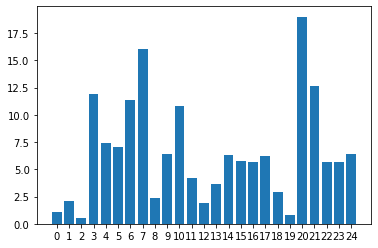

In [10]:
distribution = lda_model.transform(data_matrix)

assignment = np.argmax(distribution, axis=1)
percs = []
for i in range(topic_count):
    i_topic = data.iloc[assignment == i]
    insincere_perc = len(i_topic[i_topic["target"] == 1]) / len(i_topic) * 100.0
    print("Topic {:d} insincere percentage: {:.2f}%".format(i, insincere_perc))
    percs.append(insincere_perc)

ax = plt.subplot()
ax.bar(range(topic_count), percs)
ax.set_xticks(range(topic_count))
plt.show()

Write some code to calculate and show a bar chart denoting the percentages(and/or count) of each topic contributing to the number of insincere questions.

In [11]:
def set_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

Topic 0 insincere percentage: 0.99%
Topic 1 insincere percentage: 1.13%
Topic 2 insincere percentage: 0.58%
Topic 3 insincere percentage: 6.58%
Topic 4 insincere percentage: 4.53%
Topic 5 insincere percentage: 4.31%
Topic 6 insincere percentage: 7.03%
Topic 7 insincere percentage: 10.58%
Topic 8 insincere percentage: 1.65%
Topic 9 insincere percentage: 3.84%
Topic 10 insincere percentage: 6.55%
Topic 11 insincere percentage: 2.09%
Topic 12 insincere percentage: 1.36%
Topic 13 insincere percentage: 2.19%
Topic 14 insincere percentage: 2.94%
Topic 15 insincere percentage: 4.29%
Topic 16 insincere percentage: 3.11%
Topic 17 insincere percentage: 3.69%
Topic 18 insincere percentage: 1.58%
Topic 19 insincere percentage: 0.77%
Topic 20 insincere percentage: 12.62%
Topic 21 insincere percentage: 7.23%
Topic 22 insincere percentage: 3.13%
Topic 23 insincere percentage: 3.60%
Topic 24 insincere percentage: 3.65%


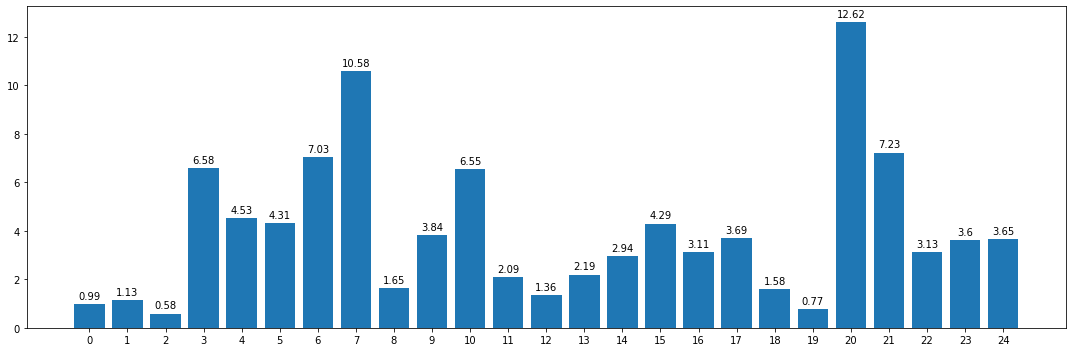

In [12]:
# get data
percs_num_insincere = []
num_insincere = len(data[data['target']==1])
for i in range(topic_count):
    i_topic = data.iloc[assignment == i]
    insincere_perc = len(i_topic[i_topic["target"] == 1]) / num_insincere * 100.0
    print("Topic {:d} insincere percentage: {:.2f}%".format(i, insincere_perc))
    percs_num_insincere.append(insincere_perc)
# draw graph
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot()
rects = ax.bar(np.arange(topic_count), percs_num_insincere)
set_labels(rects)
ax.set_xticks(range(topic_count))
fig.tight_layout()
plt.show()

Specific topics have an disproportionate amount of insincere questions. Use `.sample` to take some questions from the topic with the highest and lowest percentage of insincere questions.

In [13]:
state = 5

highest_idx = np.argmax(percs_num_insincere)
highest_samples = data.iloc[assignment == highest_idx].sample(n=10, random_state=state)
print("Highest topic samples:\n\t{:s}".format("\n\t".join(highest_samples["raw_text"])))
lowest_idx = np.argmin(percs_num_insincere)
lowest_samples = data.iloc[assignment == lowest_idx].sample(n=10, random_state=state)
print("Lowest topic samples:\n\t{:s}".format("\n\t".join(lowest_samples["raw_text"])))

Highest topic samples:
	How do you treat a person that has to feel needed to feel powerful?
	How does it feel being white and privileged at the expense of black people, such as the apartheid regime which was designed for one race to rape the other for instance?
	What was Iceland like in the 1950s?
	How do I settle in Paris?
	I seem to be governed by immense hate, how do I calm myself?
	Since global warming is an obvious hoax, how do we out these liars?
	How can one enter into investment banking? Will CFA charter help?
	How did people in Japan react to logan pauls suicide vid?
	How do you get a pet cat and pet dog and make them friends?
	Is karwachaut sexist?
Lowest topic samples:
	Is it worth doing BLIS (Bachelor in Library & Information Science) through distance mode?
	Is it good to study engineering or diploma after twelfth?
	What course has the best scope in science related to biology other than MBBS?
	What causes time to advance in space-time?
	How can an M.Tech student at any IIT 

### Alternative: Build the topic model on solely insincere data

Flipping the question since we now know that insincere questions tend to gravitate toward specific topics: Can we instead isolate the specific topics directly from the insincere portions of the data? Let's try it out. 

Build the same topic model and extract related topics just as above.

In [14]:
vectorizer_solely = CountVectorizer(max_df=0.98, min_df=5, ngram_range=(1, 2), stop_words="english")
solely_matrix = vectorizer_solely.fit_transform(data[data['target']==1]['tokenized_text'])
# fit transform the LDA model on the word count
lda_solely_model = LatentDirichletAllocation(n_components=topic_count, random_state=1)
lda_solely_model.fit(solely_matrix)

LatentDirichletAllocation(n_components=25, random_state=1)

In [15]:
top_words_lst = np.array([])
for topic_idx, topic in enumerate(lda_solely_model.components_):
    top_words = retrieve_top_words(topic, vectorizer_solely.get_feature_names(), n_top_words=10)
    print("Topic #{:d}: {:s}".format( topic_idx, ", ".join(top_words) ))
    top_words_lst = np.append(top_words_lst, top_words)

Topic #0: like, just, people, right, know, does, countries, make, look, things
Topic #1: fake, wear, house, despite, true, like, movies, indians, fucking, difference
Topic #2: america, usa, europe, world, trump, country, english, war, hate, american
Topic #3: people, anti, non, kill, getting, religious, right, want, support, finally
Topic #4: girls, questions, quora, guys, ask, question, people, indian, dumb, good
Topic #5: chinese, china, christian, poor, eat, money, like, government, rich, arrogant
Topic #6: quora, stupid, new, people, answers, think, just, does, turn, question
Topic #7: trump, supporters, gun, control, does, trump supporters, democrats, republicans, die, gun control
Topic #8: india, indians, country, north, south, indian, muslims, world, hindus, pakistan
Topic #9: god, jesus, conservatives, liberals, dog, party, hell, hindi, middle, language
Topic #10: trump, did, jewish, happen, israel, castrated, saying, working, state, called
Topic #11: women, men, woman, think, 

### Analysis

From the distribution above, we can clearly detect some words that are hotbeds for inflamatory purpose, for example, *"trump"*. Let's plug it back into our dataset as a keywords and see how many insincere questions are asked with it and how many isn't.

Set `safe_check` to False to trade accuracy for speed.

In [16]:
def keyword_percentage(dataframe, word, safe_check=True):
    if(safe_check):
        checker_fn = lambda text: word in text.lower().strip().split()
    else:
        checker_fn = lambda text: word in text.lower()
    contain = dataframe[dataframe["tokenized_text"].map(checker_fn)]
    try:
        return float(len(contain[contain["target"] == 1])) / len(contain)
    except ZeroDivisionError:
        return 0.0

test_keyword = "trump"
print("Percentage for keyword \"{:s}\": {:.2f}%".format(test_keyword, keyword_percentage(data, test_keyword) * 100.0))

Percentage for keyword "trump": 43.01%


We could easily streamline the process for the topic words generated from the model. With **3** best words per topic, display the above insincere percentage for each of them in another <u>bar chart</u>.

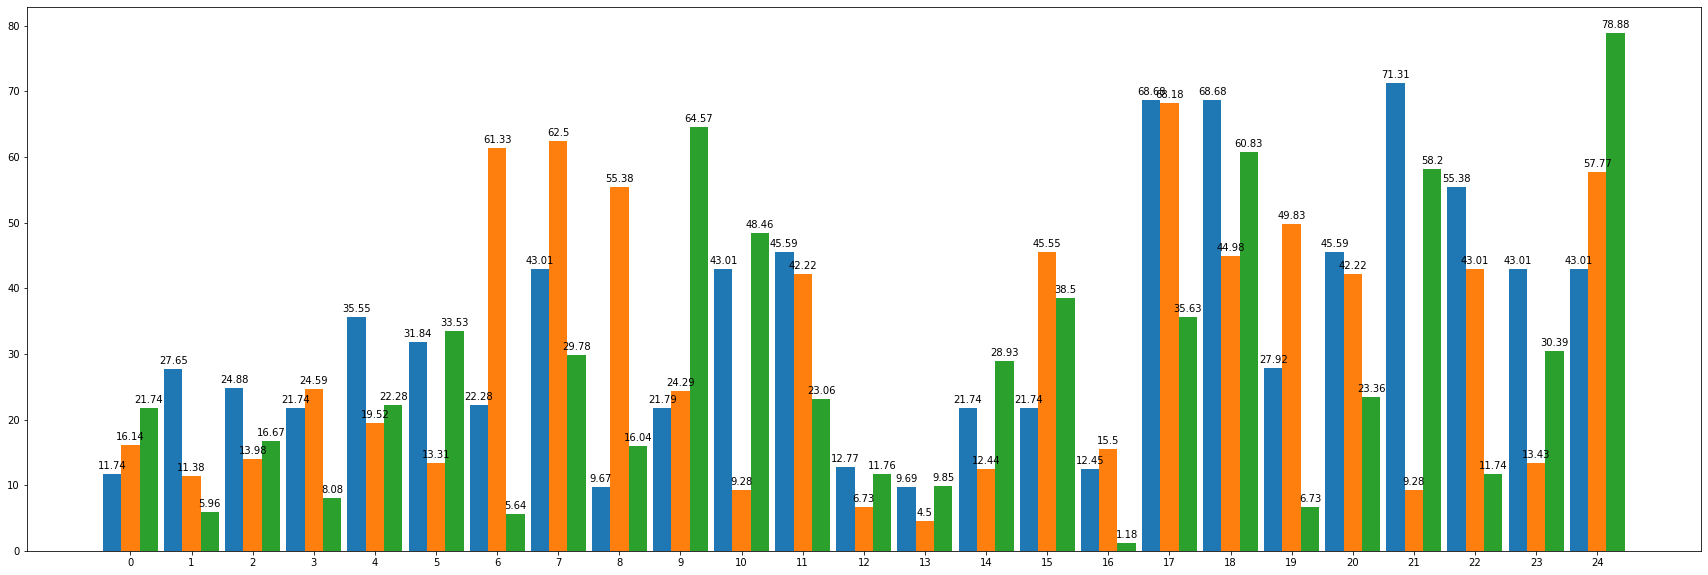

In [17]:
x = np.arange(topic_count)
top_words_percs = np.array([keyword_percentage(data, word)*100 for word in top_words_lst]).reshape(-1, 10)
width = 0.3
plt.figure(figsize=(30, 10))
ax = plt.subplot()
all_rects = [ax.bar(x - width, top_words_percs[:, 0], width),
             ax.bar(x        , top_words_percs[:, 1], width),
             ax.bar(x + width, top_words_percs[:, 2], width)]
for rects in all_rects:
    set_labels(rects)
ax.set_xticks(x)
fig.tight_layout()
plt.show()

**Optional: sample a number of random keyword (say, 5 of them) in the dataset and draw them on the bar chart along the other values.**

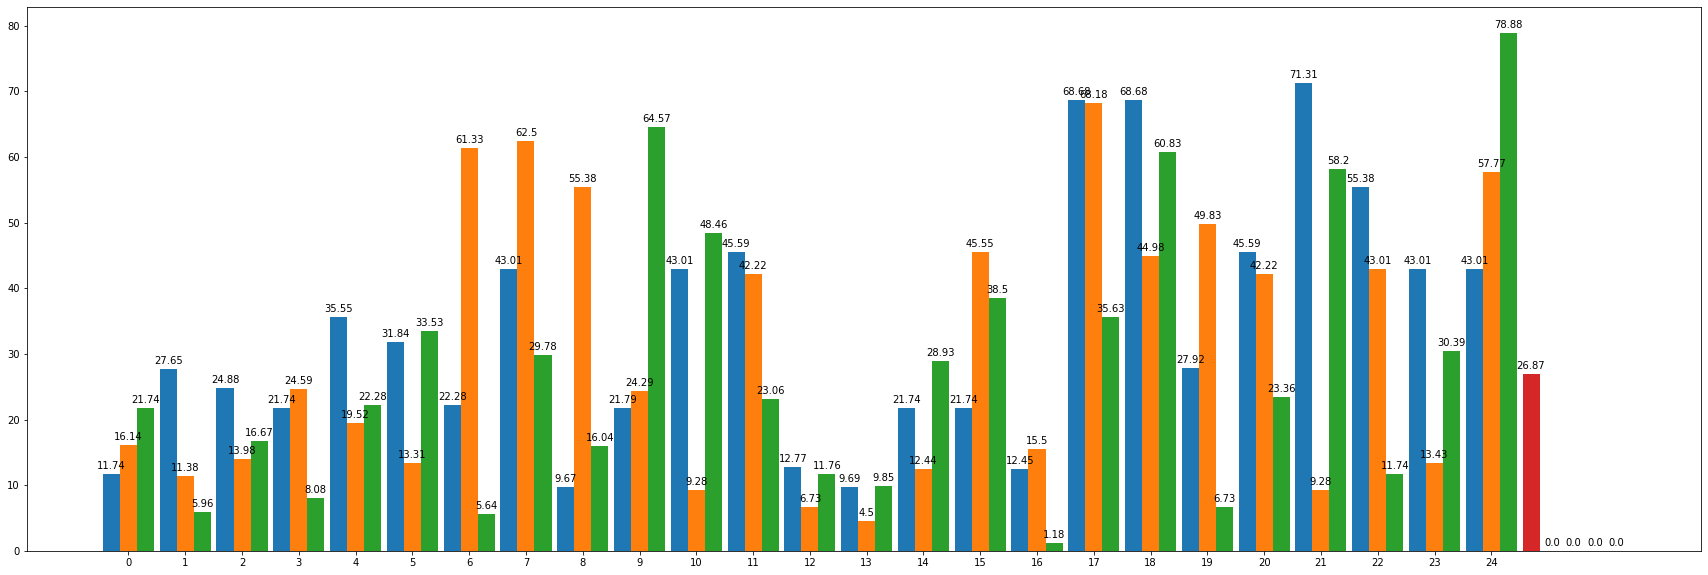

In [18]:
np.random.seed(1)
all_features_vectorizer = CountVectorizer().fit(data['tokenized_text'])
feature_names = all_features_vectorizer.get_feature_names() 
num_random_word = 5
x = np.arange(25)

width = 0.3
plt.figure(figsize=(30, 10))
ax = plt.subplot()
all_rects = [ax.bar(x - width, top_words_percs[:, 0], width),
             ax.bar(x        , top_words_percs[:, 1], width),
             ax.bar(x + width, top_words_percs[:, 2], width),
             ax.bar(np.linspace(24.7, 24.7+num_random_word*width, num_random_word), \
                   [keyword_percentage(data, word)*100.0 for word in \
                    np.random.choice(feature_names, num_random_word)], width)]
for rects in all_rects:
    set_labels(rects)
ax.set_xticks(x)
fig.tight_layout()
plt.show()


It is pretty clear that many keywords constitute a fair amount of abuse, with special cases have more than 40% of their question flagged as insincere. These keywords can be used in conjuntion with other classification methods to catch most insincere questions.

## (Optional) Advanced methods and alternatives

### Non-Negative Matrix Factorization
An alternative choice for topic modeling that we haven't had the chance to explore is Non-Negative Matrix Factorization (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF">link</a>). You can redo the above case with this module instead and see if the result improves.

In [19]:
from sklearn.decomposition import NMF
nmf_model = NMF(n_components=topic_count, init='random', random_state=1)
nmf_model.fit(data_matrix)

NMF(init='random', n_components=25, random_state=1)

In [20]:
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words = retrieve_top_words(topic, vectorizer.get_feature_names(), n_top_words=10)
    print("Topic #{:d}: {:s}".format( topic_idx, ", ".join(top_words) ))

Topic #0: know, need, really, things, love, girl, need know, does know, friend, want know
Topic #1: did, war, start, change, come, american, end, did people, obama, face
Topic #2: does, mean, does mean, long, long does, affect, feel, does feel, cost, look
Topic #3: people, white, black, white people, people think, black people, say, believe, chinese, hate
Topic #4: good, bad, good bad, business, idea, good idea, books, book, term, short
Topic #5: years, old, years old, 10, possible, experience, ago, love, years ago, 10 years
Topic #6: like, feel, look, feel like, look like, people like, girl, girls, just, really
Topic #7: best, best way, friend, book, online, best friend, ways, best ways, books, institute
Topic #8: use, using, app, people use, possible, word, instead, online, data, phone
Topic #9: way, best way, learn, way learn, money, easiest, effective, way make, start, right
Topic #10: new, york, new york, start, business, new zealand, zealand, used, company, account
Topic #11: per

Topic 0 insincere percentage: 4.16%
Topic 1 insincere percentage: 7.39%
Topic 2 insincere percentage: 5.40%
Topic 3 insincere percentage: 21.93%
Topic 4 insincere percentage: 2.83%
Topic 5 insincere percentage: 3.22%
Topic 6 insincere percentage: 9.87%
Topic 7 insincere percentage: 0.83%
Topic 8 insincere percentage: 1.68%
Topic 9 insincere percentage: 2.66%
Topic 10 insincere percentage: 1.86%
Topic 11 insincere percentage: 4.36%
Topic 12 insincere percentage: 2.86%
Topic 13 insincere percentage: 7.26%
Topic 14 insincere percentage: 10.86%
Topic 15 insincere percentage: 7.34%
Topic 16 insincere percentage: 12.74%
Topic 17 insincere percentage: 12.22%
Topic 18 insincere percentage: 26.90%
Topic 19 insincere percentage: 4.13%
Topic 20 insincere percentage: 1.29%
Topic 21 insincere percentage: 1.97%
Topic 22 insincere percentage: 7.08%
Topic 23 insincere percentage: 2.88%
Topic 24 insincere percentage: 22.02%


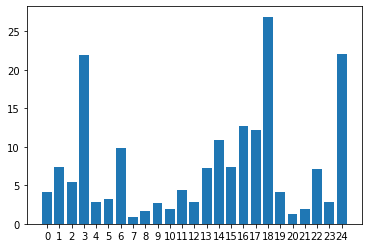

In [21]:
nmf_distribution = nmf_model.transform(data_matrix)

assignment = np.argmax(nmf_distribution, axis=1)
percs = []
for i in range(topic_count):
    i_topic = data.iloc[assignment == i]
    insincere_perc = len(i_topic[i_topic["target"] == 1]) / len(i_topic) * 100.0
    print("Topic {:d} insincere percentage: {:.2f}%".format(i, insincere_perc))
    percs.append(insincere_perc)

ax = plt.subplot()
ax.bar(range(topic_count), percs)
ax.set_xticks(range(topic_count))
plt.show()

Topic 0 insincere percentage: 7.13%
Topic 1 insincere percentage: 6.17%
Topic 2 insincere percentage: 6.17%
Topic 3 insincere percentage: 12.06%
Topic 4 insincere percentage: 1.63%
Topic 5 insincere percentage: 3.20%
Topic 6 insincere percentage: 3.45%
Topic 7 insincere percentage: 0.69%
Topic 8 insincere percentage: 1.09%
Topic 9 insincere percentage: 0.83%
Topic 10 insincere percentage: 1.57%
Topic 11 insincere percentage: 1.71%
Topic 12 insincere percentage: 0.68%
Topic 13 insincere percentage: 1.72%
Topic 14 insincere percentage: 4.16%
Topic 15 insincere percentage: 4.40%
Topic 16 insincere percentage: 2.55%
Topic 17 insincere percentage: 6.31%
Topic 18 insincere percentage: 8.18%
Topic 19 insincere percentage: 1.21%
Topic 20 insincere percentage: 2.78%
Topic 21 insincere percentage: 0.61%
Topic 22 insincere percentage: 3.70%
Topic 23 insincere percentage: 1.29%
Topic 24 insincere percentage: 16.69%


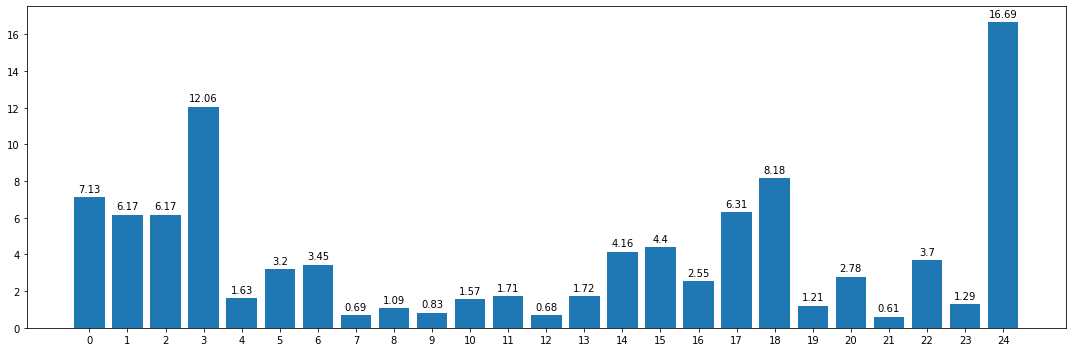

In [22]:
# get data
nmf_percs_num_insincere = []
for i in range(topic_count):
    i_topic = data.iloc[assignment == i]
    insincere_perc = len(i_topic[i_topic["target"] == 1]) / num_insincere * 100.0
    print("Topic {:d} insincere percentage: {:.2f}%".format(i, insincere_perc))
    nmf_percs_num_insincere.append(insincere_perc)
# plot bar
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot()
rects = ax.bar(np.arange(topic_count), nmf_percs_num_insincere)
set_labels(rects)
ax.set_xticks(range(topic_count))
fig.tight_layout()
plt.show()

In [23]:
state = 5

highest_idx = np.argmax(nmf_percs_num_insincere)
highest_samples = data.iloc[assignment == highest_idx].sample(n=10, random_state=state)
print("Highest topic samples:\n\t{:s}".format("\n\t".join(highest_samples["raw_text"])))
lowest_idx = np.argmin(percs_num_insincere)
lowest_samples = data.iloc[assignment == lowest_idx].sample(n=10, random_state=state)
print("Lowest topic samples:\n\t{:s}".format("\n\t".join(lowest_samples["raw_text"])))

Highest topic samples:
	Is there anyone here who has been sexually harassed by their (biological) mother?
	Why are women more sure of what they want than men?
	Where do you source X-Men Viper Cosplay Costume?
	Is it a coincidence that the jumbo straw size is exactly the same diameter as a NATO bullet size (5.56mm)?
	Where can I download soundtracks from White Collar?
	How do flower children affect society?
	Which language is required for black hacking?
	Where can I find young fashion designer in Indore?
	Do many men and women enjoy anal play?
	Is it true that Prince Harry was born with both the male and female anatomy?
Lowest topic samples:
	In simple terms, what does an IT technician do?
	How does Erik Karlsson compare to Bobby Orr as a hockey player in the NHL?
	Does joining the military give you the discipline and leadership to become a successful entrepreneur?
	How does the button that launches Google or Siri with a bluetooth headset works?
	Does becoming religious have any benefit

In [24]:
# fit transform the LDA model on the word count
nmf_solely_model = NMF(n_components=topic_count, random_state=1)
nmf_solely_model.fit(solely_matrix)

NMF(n_components=25, random_state=1)

In [25]:
nmf_top_words = np.array([])
for topic_idx, topic in enumerate(nmf_solely_model.components_):
    top_words = retrieve_top_words(topic, vectorizer_solely.get_feature_names(), n_top_words=10)
    print("Topic #{:d}: {:s}".format( topic_idx, ", ".join(top_words) ))
    nmf_top_words = np.append(nmf_top_words, top_words[:3])

Topic #0: people, white people, black people, believe, gay, stupid, people think, ca, people like, religious
Topic #1: trump, donald, donald trump, president, supporters, trump supporters, president trump, obama, hillary, liberals
Topic #2: women, white women, man, rape, women like, american women, black women, respect, day, indian women
Topic #3: muslims, christians, hindus, religion, indian muslims, islam, non, jews, true, muslim
Topic #4: does, make, mean, say, know, look, does quora, does mean, want, gay
Topic #5: like, feel, feel like, people like, look like, look, women like, things, just like, countries
Topic #6: white, white people, non, asian, non white, racist, privilege, white person, person, race
Topic #7: did, obama, make, jews, did obama, kill, russia, use, russian, europeans
Topic #8: quora, questions, question, answers, stupid, answer, ask, does quora, questions quora, people quora
Topic #9: think, people think, life, men think, better, democrats, women think, americans

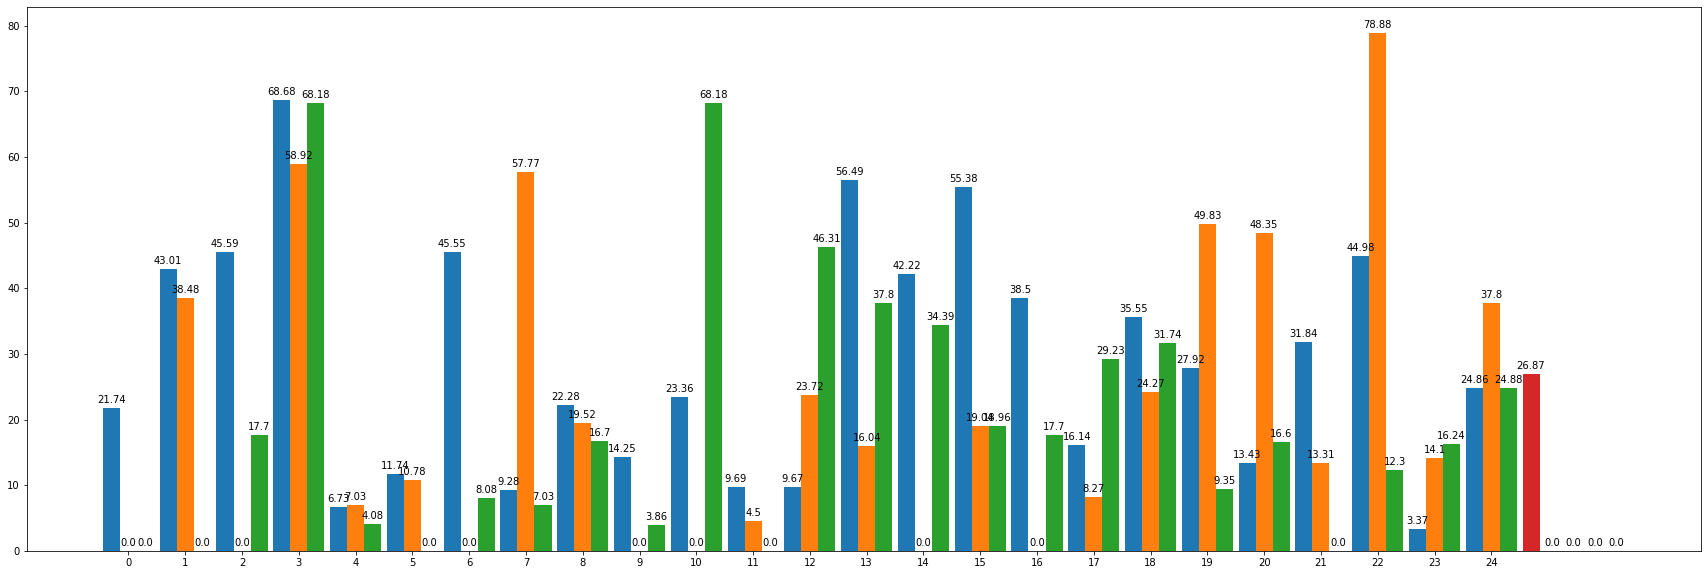

In [26]:
np.random.seed(1)
num_random_word = 5
x = np.arange(25)
nmf_top_words_percs = np.array([keyword_percentage(data, word)*100 for word in nmf_top_words]).reshape(-1, 3)
width = 0.3
plt.figure(figsize=(30, 10))
ax = plt.subplot()
all_rects = [ax.bar(x - width, nmf_top_words_percs[:,0], width),
             ax.bar(x        , nmf_top_words_percs[:,1], width),
             ax.bar(x + width, nmf_top_words_percs[:,2], width),
             ax.bar(np.linspace(24.7, 24.7+num_random_word*width, num_random_word),\
                   [keyword_percentage(data, word)*100.0 for word in \
                    np.random.choice(feature_names, num_random_word)], width)]
for rects in all_rects:
    set_labels(rects)
ax.set_xticks(x)
fig.tight_layout()
plt.show()

### Implementation of Classification

Student who had ran through the previous Classification course can try tackle this problem and see if the new insights offered in this notebook would translate to a higher accuracy score.

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
# get train and test data
train_data, test_data = train_test_split(data.dropna(subset=("tokenized_text", "target")), train_size=0.8, test_size=0.2, random_state=0)

# classifier_vectorizer = CountVectorizer()
train_features = vectorizer.transform(train_data['tokenized_text'])
train_labels = train_data['target'].astype(int).values
test_features = vectorizer.transform(test_data['tokenized_text'].values)
test_labels = test_data['target'].astype(int).values
# train model
classifier_model = LogisticRegression(max_iter=1000).fit(train_features, train_labels)

In [28]:
from sklearn.metrics import f1_score
print("f1 score on:\ntrain set: {:f}\ntest set: {:f}".\
      format(f1_score(train_labels, classifier_model.predict(train_features)),
             f1_score(test_labels, classifier_model.predict(test_features))))

f1 score on:
train set: 0.676967
test set: 0.470965


In [38]:
# models_topic = []
# for i in range(topic_count):
#     i_topic = data.iloc[assignment == i]
#     features = vectorizer.transform(data.iloc[assignment == i]['tokenized_text'])
#     labels = data.iloc[assignment==i]['target'].astype(int).values
#     models_topic.append(LogisticRegression(max_iter=1000).fit(features, labels))

In [30]:
def check_text(words_list):
    return np.any([word in key_words for word in words_list])

In [62]:
def predict(X):
    n_samples = np.shape(X)[0]
    classify_prediction = classifier_model.predict(X)
#     topic_assignment = np.argmax(lda_model.transform(X), axis=1)
#     topic_model_prediction = np.array([models_topic[topic_assignment[i]]. \
#         predict(X.getrow(i)) for i in range(n_samples)]).reshape(n_samples)
    invert_text = vectorizer.inverse_transform(X)
    contain_keyword = pd.Series(invert_text).map(check_text) 
    return classify_prediction.tolist() and contain_keyword.tolist()

In [70]:
key_words = set(top_words_lst.reshape(-1, 10)[top_words_percs > 35])
print("f1 score on:\ntrain set: {:f}\ntest set: {:f}".\
      format(f1_score(train_labels, predict(train_features)),
             f1_score(test_labels, predict(test_features))))
# 40 f1 score on:
# train set: 0.484482
# test set: 0.473960
# 35 f1 score on:
# train set: 0.491231
# test set: 0.481690

f1 score on:
train set: 0.491231
test set: 0.481690
